In [134]:
import psycopg2
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
import re
from nltk.stem import SnowballStemmer
import spacy
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

In [141]:
conn = psycopg2.connect(
    dbname="webmining",
    user="postgres",
    password="postgres",
    host="localhost",
    port="5432"
)

df_annonces = pd.read_sql_query("SELECT reference, intitule_poste, description, experience, divers FROM annonces", conn)

df_competences = pd.read_sql_query("SELECT * FROM competences", conn)

df_annonce_competences = pd.read_sql_query("""
    SELECT p.reference, p.intitule_poste, p.description, p.experience, p.divers, c.nom, c.requis
    FROM annonces p
    JOIN annonce_competences pc ON p.reference = pc.annonce_reference
    JOIN competences c ON pc.competence_id = c.id
""", conn)

conn.close()


C:\Users\Joel\AppData\Local\Temp\ipykernel_21948\568194636.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Joel\AppData\Local\Temp\ipykernel_21948\568194636.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\Joel\AppData\Local\Temp\ipykernel_21948\568194636.py:13: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



In [142]:
df_annonces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reference       112 non-null    object
 1   intitule_poste  112 non-null    object
 2   description     112 non-null    object
 3   experience      112 non-null    object
 4   divers          112 non-null    object
dtypes: object(5)
memory usage: 4.5+ KB


In [143]:
df_annonce_competences.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reference       483 non-null    object
 1   intitule_poste  483 non-null    object
 2   description     483 non-null    object
 3   experience      483 non-null    object
 4   divers          483 non-null    object
 5   nom             483 non-null    object
 6   requis          483 non-null    bool  
dtypes: bool(1), object(6)
memory usage: 23.2+ KB


In [144]:
# ajout des compétences dans le dataframe des annonces
for reference in df_annonces.loc[:,"reference"]:
    df_annonces.loc[df_annonces["reference"]==reference,"competences"] = " ".join(df_annonce_competences.loc[df_annonce_competences["reference"] == reference,"nom"])

In [145]:
df_annonces.head()

,reference,intitule_poste,description,experience,divers,competences
0,0907189,Développeur Big Data H/F,POSTE : Développeur Big Data H/F\nDESCRIPTION ...,Expérience exigée,,
1,1286647,Développeur / Développeuse Big Data (H/F),Nous recherchons un Data Engineer Sénior pour ...,Expérience exigée de 5 An(s),,
2,1480816,Data Scientist - Alternance H/F,POSTE : Data Scientist - Alternance H/F\nDESCR...,Expérience exigée,,
3,186RJZQ,Data Engineer (H/F),"Weldom, une rencontre évidente\nDes défis à re...",2 An(s),Salaire brut : A NEGOCIER,"Analyser, exploiter, structurer des données Co..."
4,187NTTM,Développeur/Développeuse Python et Data Engine...,Vous avez une expérience en matière Python et ...,5 An(s),"Salaire brut : A partir de 2 117,88 € nets",Faire preuve de curiosité Prendre des initiati...


In [147]:
df_annonces.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reference       112 non-null    object
 1   intitule_poste  112 non-null    object
 2   description     112 non-null    object
 3   experience      112 non-null    object
 4   divers          112 non-null    object
 5   competences     112 non-null    object
dtypes: object(6)
memory usage: 5.4+ KB


In [148]:
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
nltk.download('punkt')
nlp = spacy.load("fr_core_news_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [149]:
# import des stopwords proposés par Gilles Bastin
# https://github.com/gillesbastin/french_stopwords

stop_Bastin = pd.read_csv("french_stopwords.csv", sep=";")

## custom stopwords
liste de mots qui sont remontés lors des premières itérations

In [150]:
'''
    "achat", "accompagner", "assurer", "besoins", "bnf", "capacité", "capacités", "client", "compétence", "compétences",
    "connaissance", "data", "DIGITALENT", "donnees", "entreprise", "expérience", "expériences", 
    "expertise", "fort", "formation", "gestion", "groupe", "informatique" "Itéa", "logiciel", "mission", "missions", 
    "niveau", "outils", "outil", "plus", "poste", "postes", "présent", "profil", "RCA", "salesforce", 
    "seins", "sein", "société", "solution", "solutions", "support", "suivre", "technique", "techniques", 
    "travailler", "travail", "utilisateur", "équipe", "équipes", "être", 
    "métier", "métiers", "nouveau", "niveau", "présent"
    '''

'\n    "achat", "accompagner", "assurer", "besoins", "bnf", "capacité", "capacités", "client", "compétence", "compétences",\n    "connaissance", "data", "DIGITALENT", "donnees", "entreprise", "expérience", "expériences", \n    "expertise", "fort", "formation", "gestion", "groupe", "informatique" "Itéa", "logiciel", "mission", "missions", \n    "niveau", "outils", "outil", "plus", "poste", "postes", "présent", "profil", "RCA", "salesforce", \n    "seins", "sein", "société", "solution", "solutions", "support", "suivre", "technique", "techniques", \n    "travailler", "travail", "utilisateur", "équipe", "équipes", "être", \n    "métier", "métiers", "nouveau", "niveau", "présent"\n    '

In [325]:
stop = {
    "klanik", "bosch","activités","assure", "permettant", "partenaires", "côtés", "digixart", "amené", "pricing", "rythme", "développée", "précision", "daurade", "exécuter", "vacances", "clients", "données", "data", "expérience", "équipes", "compétences", "mission", "groupe", "solutions", "travail", "salesforce", "techniques", "projets","métiers", "technique", "outils", "équipe", "poste", "traitement", "an", "agence", "commerciale", "marketing", "différents", "idéalement", "activité", "logiciel", "niveau", "connaissance", "maîtrise","faciliter", "profil", "participer", "bons", "business", "projet", "manipulation", "rejoignez", "légumes", "fruits", "tickets", "building", "entreprise", "assurer", "métier", "tests", "complexes", "gestion", "capacité", "formation", "répondront", "construction", "outil", "team", "offre", "programme", "sein", "mise", "clarté", "travailler", "manuels", "suivi", "accompagner", "définition", "famille", "direction", "prime", "primes", "utilisateurs", "familiale", "annuelle", "issu", "rémunération"
}



# preprocessing

In [326]:
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))
nltk.download('punkt')
nlp = spacy.load("fr_core_news_sm")

stop_words.update(stop)
stop_words.update(set(stop_Bastin["token"]))

def preprocess(texts: str):
    '''
    supprime les nombres seuls (5, 10)
    '''
    cleaned_texts = []
    stems_texts = []
    lemmas_texts = []
    stemmer = SnowballStemmer("french")

    for text in texts:
        text = text.replace("\n", " ")
        text = text.lower()
        text = text.replace("ci/cd", "ci_cd").replace("power-bi", "power_bi").replace("big.data", "big_data")
        text = re.sub(r"[^\w\s_]", " ", text)
        text = text.replace("ci_cd", "ci/cd").replace("power_bi", "power-bi").replace("big_data", "big-data")
        text = re.sub(r"gestion de projets?", "gestion-de-projet", text)
        text = re.sub(r"_", " ", text)
        text = re.sub(r'\b\d+\b', '', text)
        # text = re.sub(f"[{string.punctuation}]", " ", text)
        text = ' '.join([word for word in text.split() if word not in stop_words])

        #stemming
        tokens = word_tokenize(text)
        stems = " ".join([stemmer.stem(word) for word in tokens])

        #lematize
        doc = nlp(text)
        lemmas = " ".join([token.lemma_ for token in doc])
        
        cleaned_texts.append(text)
        stems_texts.append(stems)
        lemmas_texts.append(lemmas)


    return cleaned_texts, stems_texts, lemmas_texts

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [327]:
texts = df_annonces["description"] + df_annonces["competences"]

In [328]:
cleaned_text, stems_texts, lemmas_texts = preprocess(texts)

# Clustering tfidf kmeans

In [329]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the job listings
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_text)


In [330]:
# with open("./model/tfidf_cleaned.joblib", "wb") as f: 
#     joblib.dump(vectorizer, f)

In [320]:
with open("./model/tfidf_cleaned.joblib", "rb") as f: 
    vectorizer = joblib.load(f)

In [331]:
X.shape

(112, 3992)

In [332]:
with open("./tokens.txt", "w")as f:
    f.write("\n".join(vectorizer.get_feature_names_out()))

In [333]:

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)

# Cluster labels
labels = kmeans.labels_
labels

array([1, 0, 2, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 3, 2,
       2, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 3, 2, 0, 0, 0,
       0, 1, 0, 3, 2, 3, 0, 0, 0, 3, 0, 3, 2, 2, 1, 2, 0, 3, 0, 0, 2, 0,
       3, 3, 1, 0, 0, 0, 1, 0, 0, 3, 3, 0, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 2], dtype=int32)

In [334]:
labels = kmeans.labels_

In [335]:
# Get the cluster centers (centroids)
cluster_centers = kmeans.cluster_centers_

# If you're using TF-IDF, the cluster centers will correspond to the terms in the vocabulary
feature_names = vectorizer.get_feature_names_out()

# Display the top terms for each cluster
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i}:")
    top_terms_idx = center.argsort()[-10:][::-1]  # Get indices of the top 10 terms
    top_terms = [feature_names[idx] for idx in top_terms_idx]
    print(", ".join(top_terms))
    print()


Cluster 0:
cloud, sécurité, architecture, azure, concevoir, gérer, ia, infrastructures, développement, informatique

Cluster 1:
spark, big, sql, pl, stockage, pipelines, détecte, conduites, massif, développeur

Cluster 2:
ia, artificielle, learning, intelligence, science, machine, aise, modèles, bnf, développement

Cluster 3:
analyse, statistiques, analyst, alternance, power, bi, produits, performance, indicateurs, master



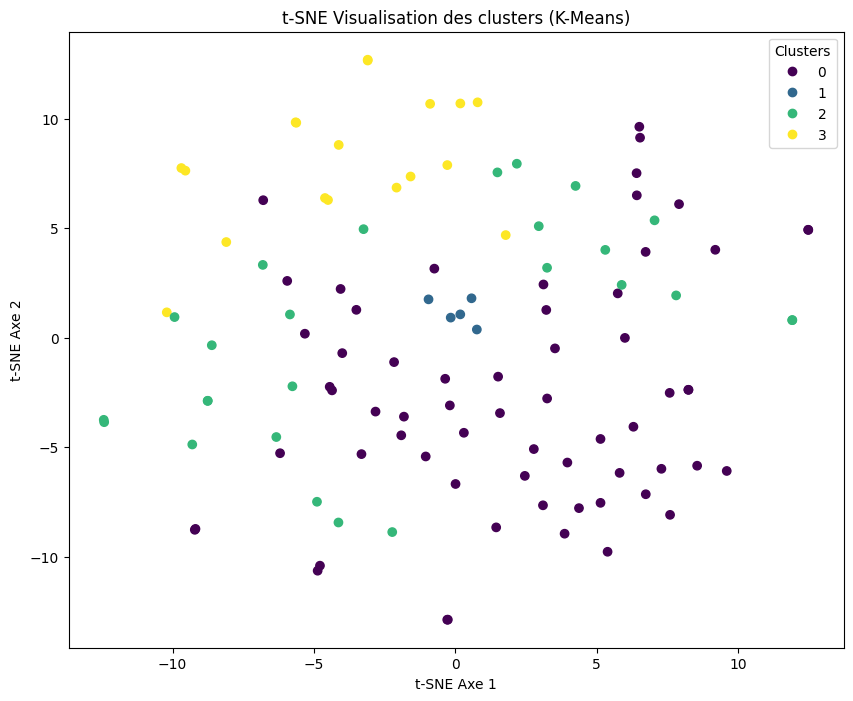

In [336]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE to reduce the dimensionality of the TF-IDF vectors
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(X.toarray())  # X is the TF-IDF matrix

# Plot the t-SNE result
plt.figure(figsize=(10, 8))

# Scatter plot with clusters, color-coded by labels
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o')

# Add title and labels
plt.title('t-SNE Visualisation des clusters (K-Means)')
plt.xlabel('t-SNE Axe 1')
plt.ylabel('t-SNE Axe 2')

# Add legend (clusters represented by unique labels)
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()


In [337]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensionality of the TF-IDF vectors
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(X.toarray())  # X is the TF-IDF matrix

# Create a DataFrame for Plotly
df_tsne = pd.DataFrame(reduced_data, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = labels  # Assign cluster labels

# Plot using Plotly Express
fig = px.scatter(df_tsne, x='TSNE1', y='TSNE2', color=df_tsne['Cluster'].astype(str),
                 title="t-SNE Visualisation des clusters (K-Means)",
                 labels={'Cluster': 'Cluster'},
                 color_discrete_sequence=px.colors.qualitative.Set1)  # Change color palette if needed

fig.show()


In [278]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the job listings using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cleaned_text)

# Apply t-SNE to reduce the dimensionality of the TF-IDF vectors to 3D
tsne = TSNE(n_components=3, random_state=42)
reduced_data = tsne.fit_transform(X.toarray())

# Assuming you have K-Means labels from the previous clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

# Create a 3D scatter plot using Plotly
fig = px.scatter_3d(
    reduced_data, 
    x=0, y=1, z=2, 
    color=labels.astype(str),  # Color points by their cluster labels
    title="Visualization des clusters Kmeans",
    labels={'0': 'Axe 1', '1': 'Axe 2', '2': 'Axe 3'},
    color_continuous_scale='Viridis'  # You can change this to another color scale
)

# Show the plot
fig.show()


# PCA

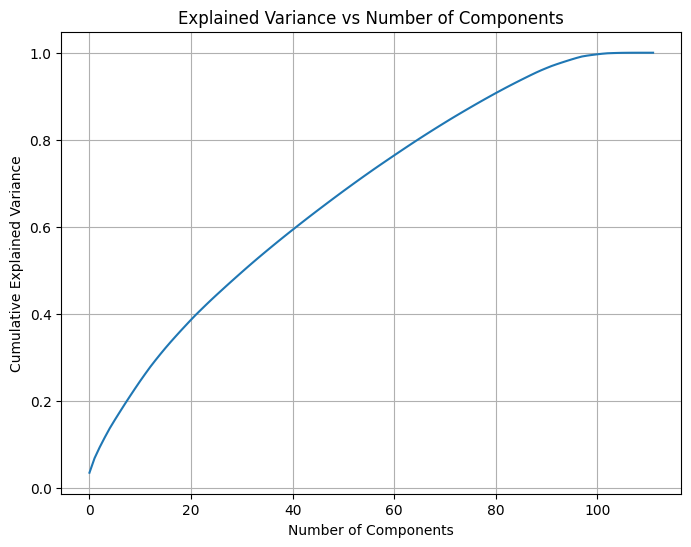

In [279]:
pca = PCA()
pca.fit(X.toarray())

# Plot the explained variance ratio for each component
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

# BERTopic

In [302]:
from bertopic import BERTopic

# Create BERTopic model
topic_model = BERTopic()
vectorizer_model = CountVectorizer(stop_words=list(stop_words))
topic_model = BERTopic(vectorizer_model=vectorizer_model)


topics_texts, _ = topic_model.fit_transform(lemmas_texts)

# View topics
print(topic_model.get_topic_info())


   Topic  Count                                        Name  \
0     -1     48                -1_dvelopper_base_ia_analyse   
1      0     33      0_analyse_informatique_service_rigueur   
2      1     17  1_cloud_architecture_scurit_infrastructure   
3      2     14                   2_ia_base_engineer_python   

                                      Representation  \
0  [dvelopper, base, ia, analyse, application, dv...   
1  [analyse, informatique, service, rigueur, beso...   
2  [cloud, architecture, scurit, infrastructure, ...   
3  [ia, base, engineer, python, sql, cloud, modle...   

                                 Representative_Docs  
0  [scientist alternance f description venir extr...  
1  [analyst lyon f description mission leyton gar...  
2  [descriptif i dsi infrastructure datacenter cl...  
3  [employeur présent salon taf secteur digitalen...  


In [303]:
topics = topic_model.get_topics()
for topic_id, words in topics.items():
    print(f"Topic {topic_id}: {words}")

Topic -1: [('dvelopper', np.float64(0.027856167071975826)), ('base', np.float64(0.027769632840810007)), ('ia', np.float64(0.0255549057140188)), ('analyse', np.float64(0.025278626278752266)), ('application', np.float64(0.024149052256056843)), ('dveloppement', np.float64(0.022122461187888274)), ('recherche', np.float64(0.021621552928907526)), ('web', np.float64(0.02072915845331323)), ('concevoir', np.float64(0.02069918764804872)), ('informatique', np.float64(0.02054952830219941))]
Topic 0: [('analyse', np.float64(0.03563755984473047)), ('informatique', np.float64(0.024831877556783618)), ('service', np.float64(0.024160745730924603)), ('rigueur', np.float64(0.019446903894181255)), ('besoin', np.float64(0.019054820816003234)), ('ia', np.float64(0.01905382287071731)), ('information', np.float64(0.018121349119750385)), ('systme', np.float64(0.01802230782400019)), ('volution', np.float64(0.017812465224577773)), ('processus', np.float64(0.017687066403640265))]
Topic 1: [('cloud', np.float64(0.1

In [ ]:
# with open("./BERTopic/model.joblib", "wb") as f: 
#     joblib.dump(topic_model, f)

In [471]:
# loaded_topic_model = joblib.load('./BERTopic/model1.joblib')

In [472]:
# topics = loaded_topic_model.get_topics()
# for topic_id, words in topics.items():
#     print(f"Topic {topic_id}: {words}")

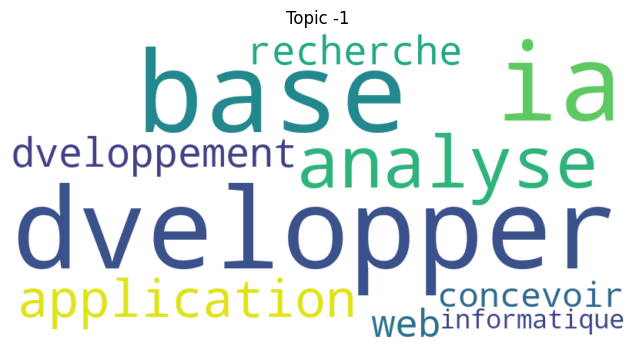

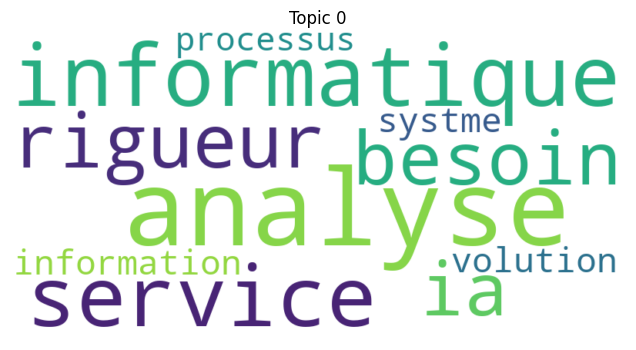

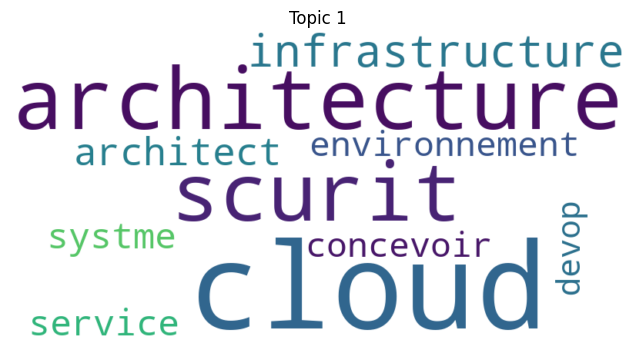

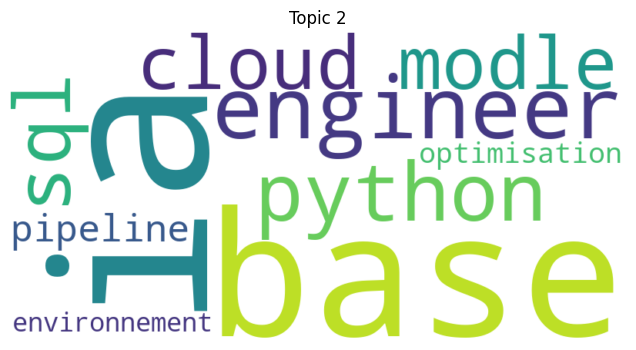

In [305]:
topic_model = joblib.load('./BERTopic/model.joblib')

topics = topic_model.get_topics()

# Create a WordCloud for each topic
for topic_num, words in topics.items():
    # Create a dictionary of word: weight (importance)
    word_freq = {word: weight for word, weight in words}

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_num}")
    plt.show()


# Embeddings

In [ ]:
HF_TOKEN= "Huggingface token"
if HF_TOKEN == "Huggingface token":
    raise "Il faut renseigner le token ci-dessus"


In [340]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("flaubert/flaubert_base_uncased")
model = AutoModel.from_pretrained("flaubert/flaubert_base_uncased")



In [ ]:
embeddings = []
for text in cleaned_text:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

    with torch.no_grad(): 
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    cls_embedding = last_hidden_states[:, 0, :]

    embeddings.append(cls_embedding)

In [346]:
with open("embeddings.joblib", "wb") as f:
    joblib.dump(embeddings, f)